# <h1 align="center">Automated Sentiment Analysis: A Case Study on movie reviews</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset, there are 25,000 labelled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)


## <h2 align = "center" >Dependecies</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## <h2> <center>Preliminary Data Exploration</center></h2>

In [ ]:
# read from local
# movies = pd.read_csv('data/imdb_data.csv')
# movies.sample(7)

In [3]:
# for importing data to colab
from google.colab import drive 
drive.mount('/content/drive')

movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/imdb_data.csv')
movies.sample(7)

,review,sentiment
18520,"""The Haunted World of Edward D. Wood, Jr."" is ...",positive
3684,It has a bit of that indie queer edge that was...,negative
43290,A made for television version of the Heart of ...,negative
46851,Well to start with I'm straight up as black as...,negative
30151,"What the ........... is this ? This must, with...",negative
30956,This show has a great storyline! It's very bel...,positive
39720,There is a lot wrong with this movie. It can b...,negative


In [4]:
movies.dtypes

review       object
sentiment    object
dtype: object

In [5]:
movies.isna().sum()

review       0
sentiment    0
dtype: int64

In [6]:
#sentiment count
movies['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

> No missing values in the dataset

In [7]:
# Looking at sample review
sample = 777
sample_review = movies.review.iloc[sample]
print(sample_review)
print("\nAssigned sentiment: ", movies.sentiment.iloc[sample])

It's amazing that such a cliche-ridden yuppie angst film actually got made in the first place. The characters are so weak, and the acting so uninspired, that it's impossible to care about any of them-- especially Brooke Shields. The temptation to fast forward through the slow parts is almost irresistible. If you like this genre, you'd be better off renting "Singles," or "Bodies, Rest & Motion."

Assigned sentiment:  negative


> **Contains html tags, accented characters, punctutations and emoticons, numbers... etc., Should deal with them in the preprocessing step**

In [8]:
# Cateogrize positive and negative as 1 and 0 respectively
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

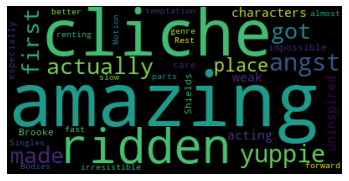

In [10]:
from wordcloud import WordCloud, STOPWORDS

my_stop_wrods = set(STOPWORDS)
my_stop_words = STOPWORDS.update(['movie', 'movies', 'film', 'films', 'br'])

my_cloud = WordCloud(stopwords=my_stop_words).generate(sample_review)
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

## <h2> <center>Preprocessing</center></h2>

In [11]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import os
import multiprocessing

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
!pip install langdetect

In [13]:
# Looking for languages
from langdetect import detect_langs

languages =[]
# pick 500 random reviews out of the dataset as langauge detection on every review is not feasible
samples = np.random.choice(len(movies.review), size = 100, replace = False)
# Loop over the rows of the dataset and append  
for row in samples:
    languages.append(detect_langs(movies.review[row]))

# Clean the list by splitting     
languages = [str(lang).split(':')[0][1:] for lang in languages]

print("Unique languages in the reviews: ", np.unique(languages))

Unique languages in the reviews:  ['en']


> **We can be fairly certain all the reviews are in english. No need to consider other languages while preprocessing**

In [0]:
# Finding out the most frequent words in our specific dataset to add stopwords customized to the movie reviews domain
from collections import Counter

top_N = 50

stopwords = nltk.corpus.stopwords.words('english')
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (movies.review
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DataFrame out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [15]:
rslt.transpose()

Word,',/><br,.,movie,",",/>,film,one,like,(,would,even,good,really,see,-,get,much,story,also,time,great,first,make,people,could,"""",made,bad,think,many,<br,never,two,little,well,watch,way,movie.,know,love,best,seen,characters,.<br,character,movies,ever,still,films
Frequency,154326,100980,62875,61492,61228,56642,55086,44983,37281,25317,23807,23681,23467,21805,20901,19159,17689,17278,16810,15743,15658,15465,15455,15028,15028,14927,14384,13562,13494,13304,12877,12764,12621,12189,11827,11692,11461,11375,10902,10784,10748,10743,10611,10599,10474,10386,10349,10218,9778,9578


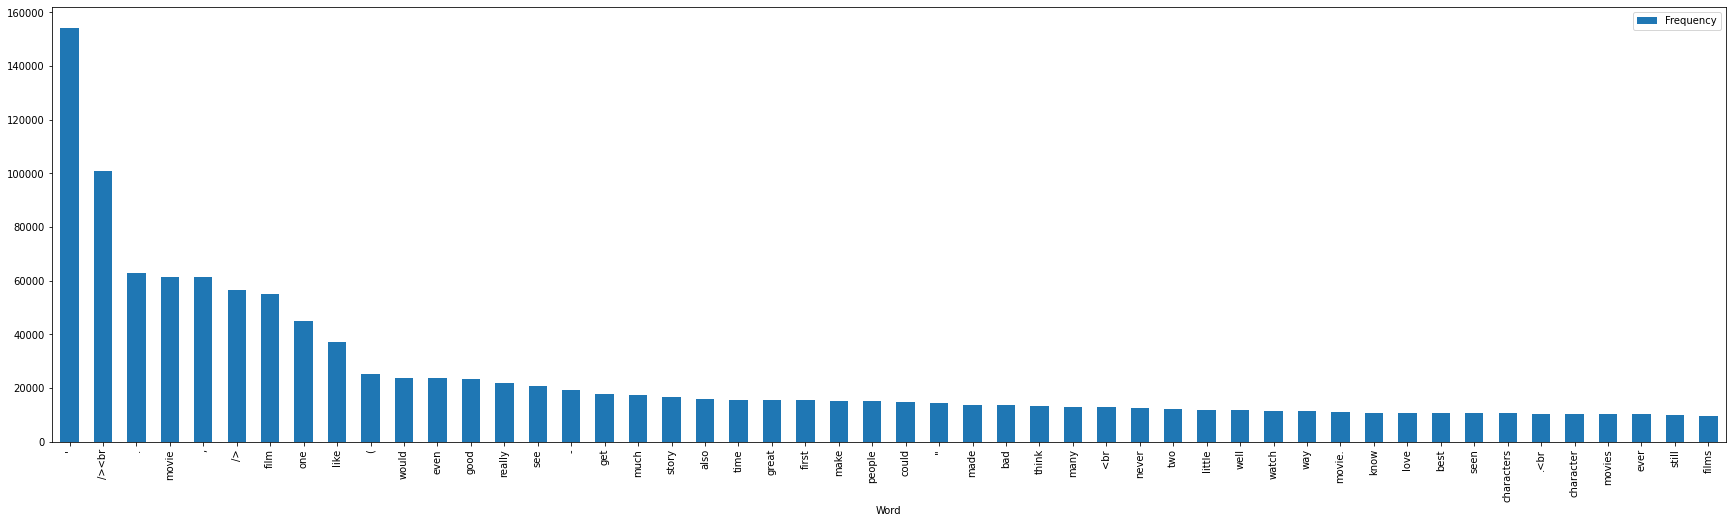

In [16]:
# plot
rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

### <h2> <center>Helper functions to aid in preprocessing the text </center></h2>

In [17]:
def sample_reviews(samples = 7):
    for review in movies['review'].sample(samples):
        print(review)
        print("")

sample_reviews()

I often wonder how movies like this even get made, and the most shocking part is that people actually pay to watch them.<br /><br />With Aksar it appears as though the director made up the story as he went along, adding twists and turns when he liked, no matter how ludicrous they were. The script was non existent with inane dialogs such as "Jo Sheena Roy pehenti hai, wahee fashion hota hai" and "Yeh Versace hai Madam" (yeah right).<br /><br />Every one of the characters was shallow and underdeveloped. Acting was awful. Constumes (lycra for Udita and awful suits for a stocky Emran), locales (the numerous houses that were used for interiors did not even vaguely resemble a Victorian mansion), screenplay etc etc, just one word- rubbish.<br /><br />For those people who love Hashmi and his movies, watch it. As for me, I'll never get those two and a half hours back. The only redeeming factor was some of the music which was decent.

This is my fourth review of a Charlie Chan movie in series ch

In [18]:
def strip_html_tags(review_text):
    soup = BeautifulSoup(review_text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text
movies['review'] = movies['review'].apply(strip_html_tags)
sample_reviews()

Truly awful film made by cinematographer-turned-director Ted Tetzlaff. Decent enough looking film but for a time-bomb movie totally devoid of any tension whatsoever. Ford, as someone put it here, sleepwalks though this one with his characteristic smirk. There are some details thrown around- Canadian ex-army or RAF, defused bombs in the war, his wife is leaving him- but none of these back stories add up to much. The bomber himself is a complete mystery. Why is he trying to blow up this shipment of mines? For that matter, what time period are we talking about here? WWII or postwar?? I assumed the latter which makes bomber's motive even more salient. Generally, though, just a horrible film. There are plenty of good time-bomb flicks to skip this one. Watch any episode of "Danger UXB" for a more exciting time, at about the same running time.

Swift's writing really has more in common with Kafka and Orwell than with fantasy-adventure writers, so it's curious that Gulliver's Travels has been 

In [19]:
import unicodedata

def replace_accented_chars(review_text):
    unaccented_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return unaccented_text
movies['review'] = movies['review'].apply(replace_accented_chars)
sample_reviews()

On the surface the idea of Omen 4 was good. It's nice to see that the devil child could be a girl. In fact, sometimes, as in the Exorcist, when girls are possessed or are devilry it's very effective. But in Omen 4, it stunk.Delia does not make me think that she could be a devil child, rather she is a child with issues. Issues that maybe only a therapist, rather then a priest could help. She does not look scary or devilish. Rather, she looks sulky and moody.This film had potential and if it was made by the same people who had made the previous three films it could of worked. But it's rather insulting really to make a sequel to one of the most favoured horror trilogies, as a made for TV movie special.On so many levels it lets down. It's cheap looking, the acting is hammish and the effects are typical of a TV drama. The characters do not bring any sympathy, and you do not route for them. I recently re-watched it after someone brought it for me for Christmas, and it has dated appalling.If 

In [20]:
def remove_special_characters(review_text):
    """ 
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review """
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_special_characters)
sample_reviews()

This is my second time through for A Perfect Spy  I watched it 2 or 3 years ago and liked it  I like it still  It's natural that it gets compared to the beeb's other big Le Carre' series  Tinker Tailor Soldier Spy  Tinker Tailor focuses on the  game  spies play  Perfect Spy gives us the other axis   what kind of person a spy is  There are a number of themes that these movies share  along with others in the genre Ambiguity   moral  sexual  interpersonal   which creates a multidimensional space of true vs  false  inside vs  outside  love vs  responsibility  In a way  these characters are happiest when they are being treated the most shabbily by those they love and respect    backstabbed  in its various nuances The theme of fathers and father figures is also important  One of the most intriguing characters in A Perfect Spy is Rick  the main character Magnus' perhaps ersatz father  Throughout the story he betrays and is betrayed  A rogue who always manages to climb back up the ladder when 

In [21]:
!pip install contractions
!pip install textsearch

In [22]:
import contractions
def expand_contractions(review_text):
    review_text = contractions.fix(review_text)
    return review_text
movies['review'] = movies['review'].apply(expand_contractions)
sample_reviews()

A repressed housewife  an annoying lisping Angie Dickinson  whose body double treats horrifies us with an extreme closeup of her delicates  is sexually bored by her husband and decides to branch out  This directly results in a string of murders that soon involve a high class prostitute  Nancy Allen  clearly I am in the wrong business if SHE can bring home  600 a night  and her psychologist  Michael Caine   If you are going to watch De Palma rip off  excuse me   pay homage to   Hitchcock  watch  Sisters  instead of this   Dressed to Kill   while loaded with style and technical skill  is one of the tackiest thrillers I have had the displeasure of sitting through  The plot is absurd and tired  It does feature some surprisingly effective jump scares and nasty graphic murder sequences that should please any horror fan  as long as they can get past the silly story line  that must have been dated even in 1980 

Looking at these reviews and seeing all these high ratings leave me to believe tha

In [23]:
# takes time ...
def strip_stops(review_text, is_lower_case=False, custom = True):
    tokens = word_tokenize(review_text)
    tokens = [token.strip() for token in tokens]
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        # custom stopwords added from the most frequent words which are generic 
        # and might not relate to the sentiment of the review
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 
                           'movies', 'films', 'cinema',
                           'character', 'show', "'", "!", 'like'])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

movies['review'] = movies['review'].apply(strip_stops)
sample_reviews()

covers every area creative process goes three stages chronologically main focus squarely placed production documentaries go detail cover two groups better consists artwork behind scenes footage clips many interviews running time comes two hours audience entitled lot information given nearly length could argued lot time spent people craft result collaborative efforts coming second well done tight editing gets technology reveals certain effects achieved spends lot time physical training preparation fighting get nice candid shots people crew actors alike Ultimate Matrix 10 Disc Set also holds nearly three hours music simple system individual track selection Play function 38 minutes worth BTS material addition title various featurettes original release however several brief extras including clips making sequels preview Animatrix Yuen Wo Ping 's Blocking Tapes complete run couple biggest martial arts sequences stunt performers almost exact cinematography shots angles bits finished silver sc

In [24]:
# takes time ...
def snowball_stem(review_text):
    words = review_text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    review_text = " ".join(stemmed_words)
    return review_text

movies['review']=movies['review'].apply(snowball_stem)
sample_reviews()

first sinc peopl never saw mst3k chop version comment howev see origin version sci fi channel thought good anyth els channel fact thought better offer notic perus comment peopl write detail soultak modicum intellig thought matur tend least thing right origin cut reason peopl think probabl rate least 4 5 star 10 five averag think averag sci fi pic contrast also notic review seem immatur dull flip result come bonehead stand one find anyth good basic trash without base most see chop fricasse mst3k seen cut seem great prejud mst3k view begin

steep religion imposs separ religion comment upon opinion pretend explor deep issu thrive stereotyp prejudic littl true insight peopl therefor writer fail see grace fail understand god author beauti creator passion sexual gratif proper context marriag bond impli peopl societi stori base believ nuditi sin man woman enjoy act marriag dirti oversimplif stereotyp realli exist jewish holi write speak clear care husband seek wife 's pleasur scriptur say man

> Notice the many ' and 's left as tokens which are not relevent

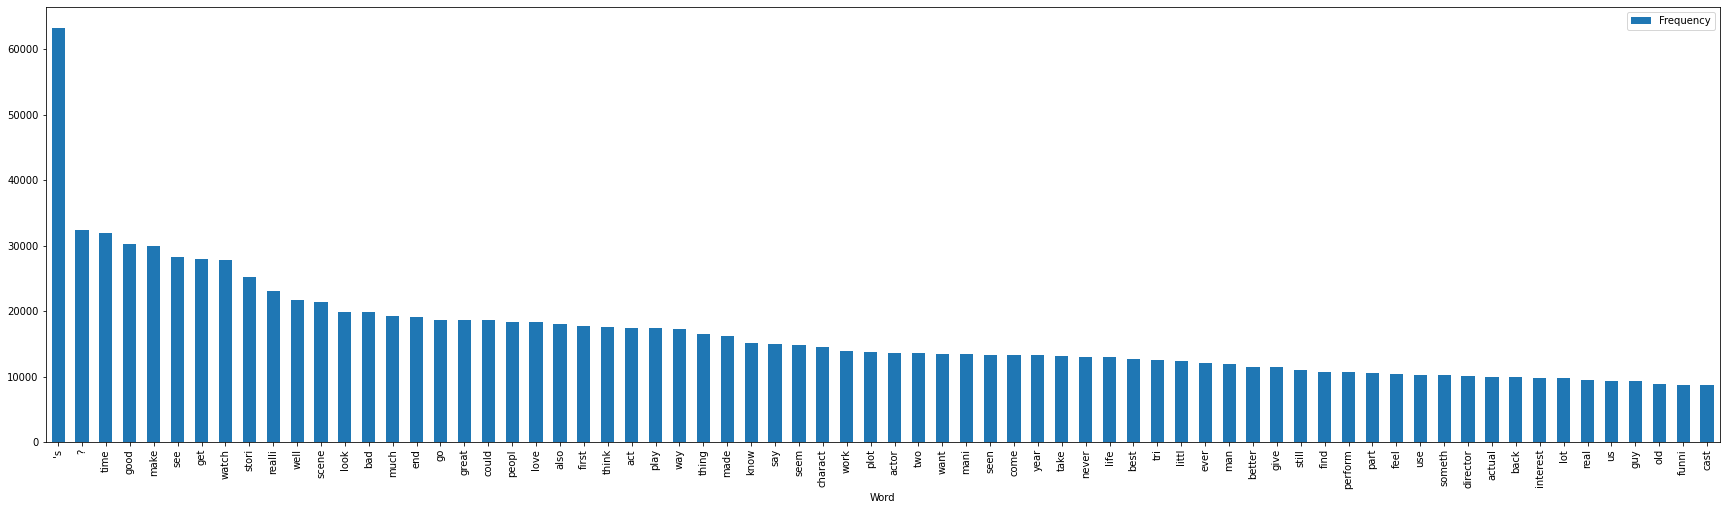

In [25]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [26]:
rslt.transpose()

Word,'s,?,time,good,make,see,get,watch,stori,realli,well,scene,look,bad,much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,charact,work,plot,actor,two,want,mani,seen,come,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy,old,funni,cast
Frequency,63260,32336,31944,30175,30012,28229,27958,27868,25268,23089,21769,21428,19935,19805,19313,19086,18716,18699,18586,18372,18300,17972,17739,17543,17479,17364,17227,16505,16149,15176,14986,14857,14447,13885,13793,13592,13541,13498,13482,13370,13255,13254,13149,12979,12926,12625,12521,12424,12027,11960,11453,11436,10932,10775,10726,10534,10350,10226,10212,10034,10007,9946,9758,9719,9430,9383,9252,8804,8763,8755


In [27]:
def remove_apostrophe_s(review_text):
    review_text = re.sub(r"\'s", "", review_text)
    # review_text = re.sub(r"\s{2,}", " ", review_text)
    return review_text

movies['review'] = movies['review'].apply(remove_apostrophe_s)
sample_reviews()

sort use get week day rare see drama depend cast talk explos car chase chase impli sexual situat younger crowd appreci peopl talk argu lot marri coupl mid life problem emili watson tom wilkinson seem happi middl age love man wife live small london suburb handsom rupert everett return home visit wealthi father cours meet emili watson easi anyon smitten emili say except credit begin fatal accid rest repercuss accid lie various charact tell act trio other excel julien fellow wrote screenplay base novel nigel balchin also direct first directori attempt well entir product first rate month theatric run late 2005 80 theatr shame stupid comedi open least 2000 screen real good dram mani other open way funni line regard certain situat rate 1 2 4 95 point 100 imdb 9 10

serious imagin anyon could find singl flatter thing say much less find write glow compliment contain comment section mani methamphetamin bogdonovitch film ? give bonus actor spat line speed least inflect thought ? dialogu bad plot

In [28]:
movies.sample(7)

,review,sentiment
15146,stori ned kelli enshroud myth exagger time han...,1
22018,vice versa french noir direct american maker j...,1
3372,peopl actual like problem child 1990 need head...,0
49726,honest watch origin howl scene saw made obviou...,0
6234,agre previous post cinematographi good total d...,0
15241,ok make good ? well realli opinion whole lot r...,0
30734,usual walk halfway thru promis someth differ k...,0


In [29]:
movies.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [0]:
movies.to_csv('/content/drive/My Drive/Colab Notebooks/cleaned_data.csv')

## <h2> <center>Visualize the data</center></h2>

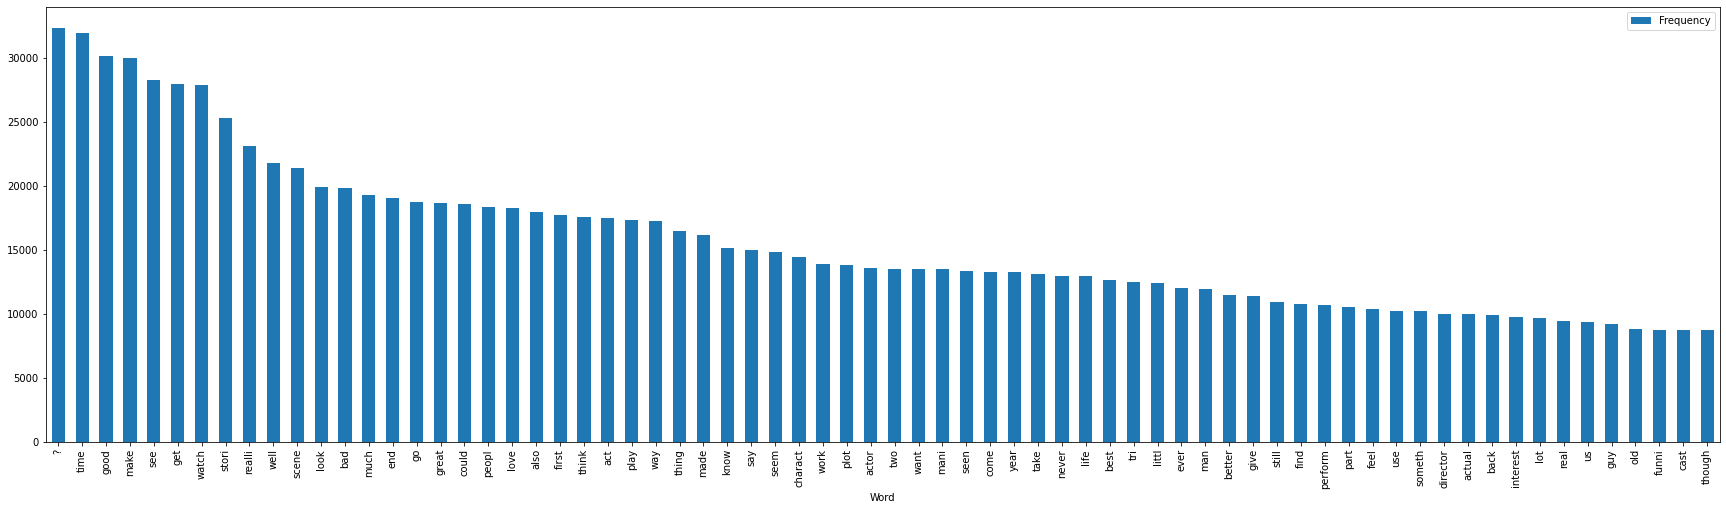

In [31]:
top_N = 70

words = (movies.review.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [32]:
rslt.transpose()

Word,?,time,good,make,see,get,watch,stori,realli,well,scene,look,bad,much,end,go,great,could,peopl,love,also,first,think,act,play,way,thing,made,know,say,seem,charact,work,plot,actor,two,want,mani,seen,come,year,take,never,life,best,tri,littl,ever,man,better,give,still,find,perform,part,feel,use,someth,director,actual,back,interest,lot,real,us,guy,old,funni,cast,though
Frequency,32336,31944,30175,30012,28229,27958,27868,25268,23089,21769,21428,19935,19805,19313,19086,18716,18699,18586,18372,18300,17972,17739,17543,17479,17364,17227,16505,16149,15176,14986,14857,14447,13885,13793,13592,13541,13498,13482,13370,13255,13254,13149,12979,12926,12625,12521,12424,12027,11960,11453,11436,10932,10775,10726,10534,10350,10226,10212,10034,10007,9946,9758,9719,9430,9383,9252,8804,8763,8755,8748


<h2><center> Visualize the positive and negative reviews as wordclouds </center></h2>


In [0]:
pos_string = ""
pos = movies.loc[movies.sentiment == 1, 'review']
for review in pos:
    pos_string += review
    pos_string += " "

neg_string = ""
neg = movies.loc[movies.sentiment == 0, 'review']
for review in neg:
    neg_string += review
    neg_string += " "

<center> <h2>Positve Reviews WordCloud</h2></center>


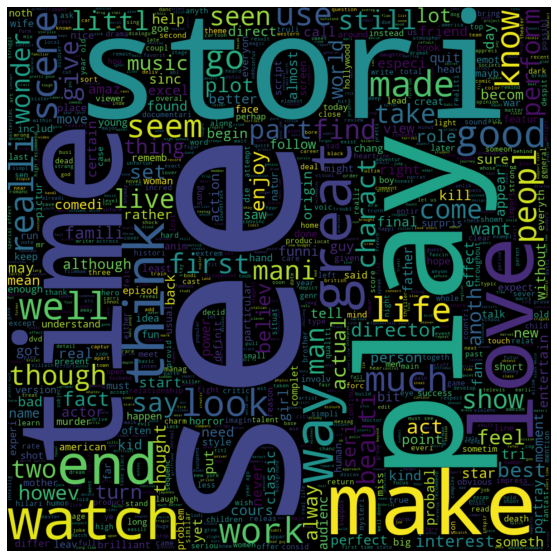

In [34]:
plt.figure(figsize=(10,10))
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
positive_words = WC.generate(pos_string)
plt.imshow(positive_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative reviews WordCloud</h2></center>


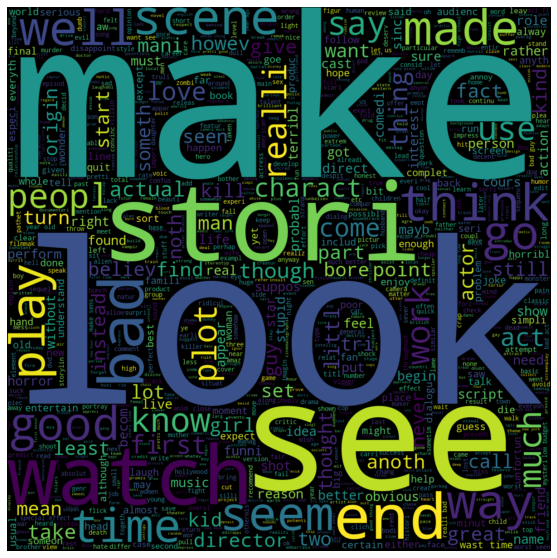

In [35]:
plt.figure(figsize=(10,10))
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
negative_words = WC.generate(neg_string)
plt.imshow(negative_words,interpolation='bilinear')
plt.axis("off")
plt.show()

<center> <h2>Negative  reviews top 50 word frequency distribution</h2></center>


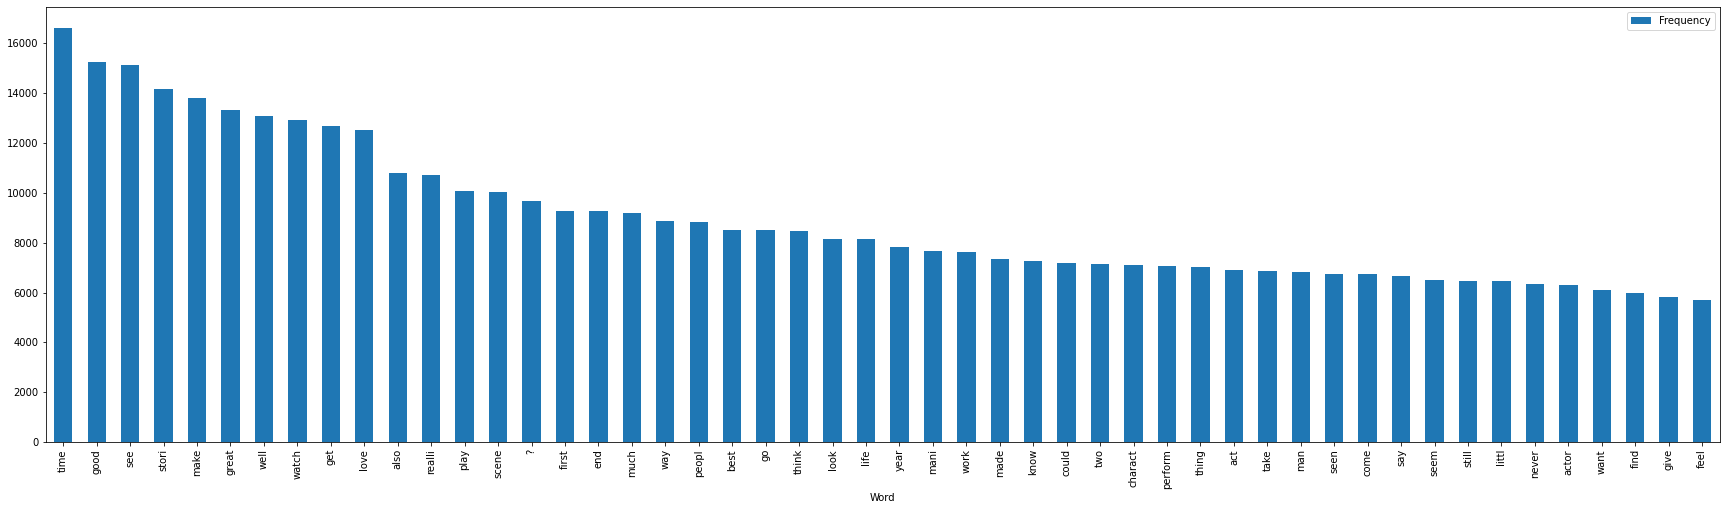

In [36]:
top_N = 50

words = (pos.str.cat(sep=' ').split())
pos_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

pos_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

In [37]:
pos_freq.transpose()

Word,time,good,see,stori,make,great,well,watch,get,love,also,realli,play,scene,?,first,end,much,way,peopl,best,go,think,look,life,year,mani,work,made,know,could,two,charact,perform,thing,act,take,man,seen,come,say,seem,still,littl,never,actor,want,find,give,feel
Frequency,16620,15258,15131,14185,13808,13332,13064,12904,12690,12523,10792,10736,10065,10054,9669,9286,9282,9197,8857,8828,8520,8497,8486,8165,8141,7821,7661,7625,7348,7258,7200,7159,7100,7062,7037,6904,6847,6821,6757,6728,6656,6505,6460,6454,6334,6314,6093,5995,5840,5690


In [38]:
top_N = 50

words = (neg.str.cat(sep=' ').split())
neg_freq = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
neg_freq.transpose()

Word,?,make,bad,time,get,watch,good,see,realli,look,could,scene,stori,act,go,much,end,peopl,thing,think,made,well,plot,first,way,seem,say,know,tri,want,charact,play,actor,also,better,never,seen,ever,come,two,take,work,littl,actual,someth,noth,mani,love,guy,give
Frequency,22667,16204,15844,15324,15268,14964,14917,13098,12353,11770,11386,11374,11083,10575,10219,10116,9804,9544,9468,9057,8801,8705,8659,8453,8370,8352,8330,7918,7609,7405,7347,7299,7278,7180,6742,6645,6613,6572,6527,6382,6302,6260,5970,5938,5896,5893,5821,5777,5775,5596


* Character, show, ' 
* like, ! 
* time scene end
* make see



<center> <h2>Positve  reviews top 50 word frequency distribution</h2></center>


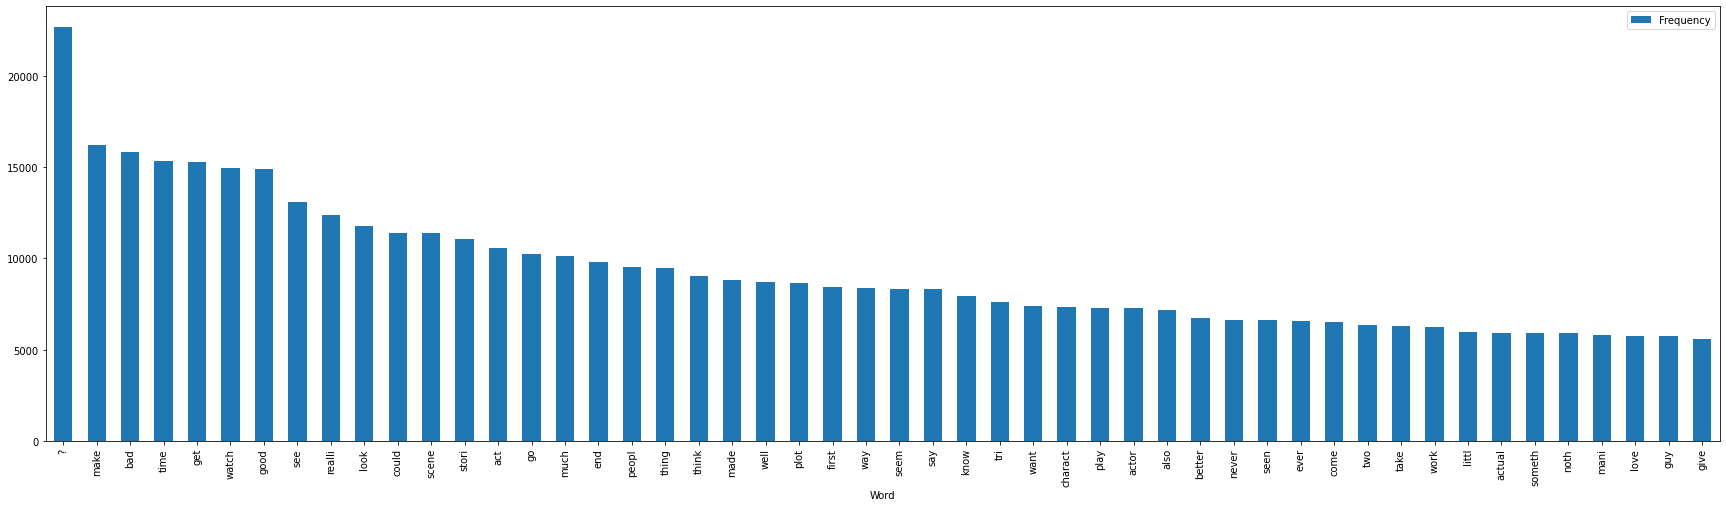

In [39]:
neg_freq.plot.bar(rot=0, figsize=(30,8), width=0.55)
plt.xticks(rotation=90)
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of all movie Reviews</h2></center>


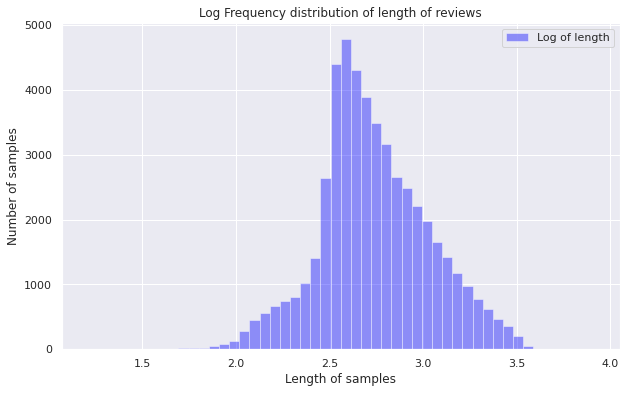

In [40]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(movies['review'])], 50, kde = False, 
             color = "blue", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of reviews')
plt.legend()
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of Positive Reviews</h2></center>


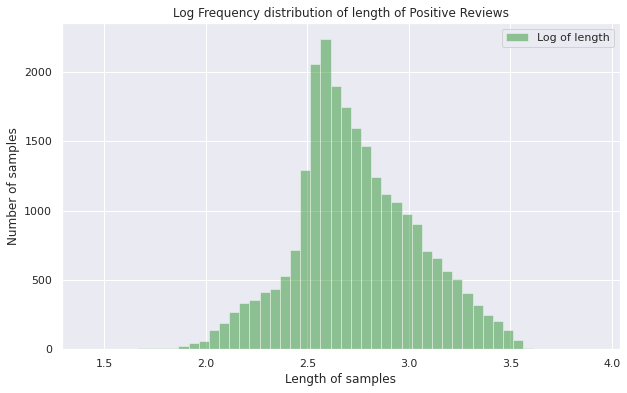

In [41]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(pos)], 50, kde = False, 
             color = "green", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Positive Reviews')
plt.legend()
plt.show()

<center> <h2>Logarithmically scaled Frequency distribution of length of Negative Reviews</h2></center>


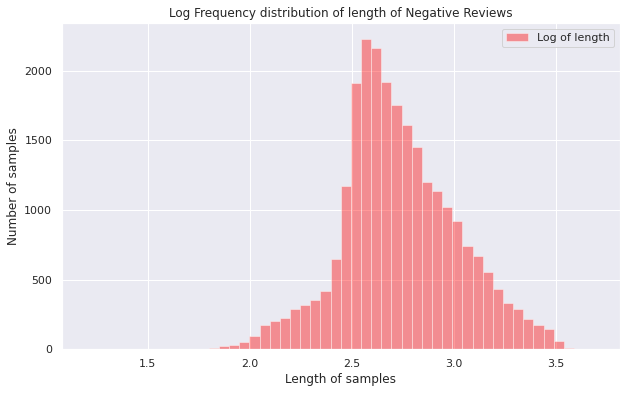

In [42]:
# Now, let's see the average number of words per sample
sns.set(rc={'figure.figsize' : (10, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
plt.figure(figsize=(10, 6))

sns.distplot([np.log10(len(review)) for review in list(neg)], 50, kde = False, 
             color = "red", label = "Log of length")
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Log Frequency distribution of length of Negative Reviews')
plt.legend()
plt.show()

> **There is no significant difference in the length of positve and negative reviews**